<a href="https://colab.research.google.com/github/gazon1/testing-task-Avito/blob/master/Stacking_xgboost_of_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Описание задания](https://docs.google.com/document/d/19L0AkNF9HOvHquUBlNCCwuuWBymVqrEtlburUzjbya8/edit)


[форма подачи заявки на стажировку](https://start.avito.ru/)

In [22]:
# подключаем гугл диск
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
import pandas as pd
import numpy as np
import json
import os

from xgboost import  XGBClassifier
import joblib # for saving xgb model

# statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc

from tqdm import tqdm
tqdm.pandas()

# for generating text features
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



AVITO_PATH = '/content/gdrive/My Drive/avito'             # в этой папке лежат папки с кодом, данными и моделями
DATA_PATH = os.path.join(AVITO_PATH, 'data')              # здесь лежат исходные и преобразованные данные
FASTTEXT_PATH = os.path.join(AVITO_PATH, "fastText")      # папка, куда скачивается fastText
MODELS_PATH = os.path.join(AVITO_PATH, 'models')          # здесь хранятся обученные модели

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
!ls "$AVITO_PATH"

'Accuracy по каждому уровню иерархии.txt'   code   data   fastText   models


In [30]:
!ls "$DATA_PATH"

5_preds_of_fasttext.test.csv   preprocessed_train.csv
5_preds_of_fasttext.train.csv  preprocessed_train.train.csv
5_preds_of_fasttext.val.csv    preprocessed_train.val.csv
category.csv		       test.csv
cat_hier.csv		       test_lemmatized.csv
fasttext_input.train.txt       train.csv
fasttext_input.txt	       train_lemmatized.csv
fasttext_input.val.txt	       xgb_test_data.csv
fasttext_test.txt	       xgb_train_data.csv
predictions_for_test_data.csv  xgb_val_data.csv
preprocessed_test.csv


In [31]:
!ls "$MODELS_PATH"

ff_model.bin  xgb_model_600_est


# Обучаем fasttext

In [0]:
%%shell
# нужно сначала удалить старую папку fasttext, иначе не сработает
path='/content/gdrive/My Drive/avito/fastText' # == FASTTEXT_PATH
git clone https://github.com/facebookresearch/fastText.git "$path"
cd "$path"
sudo make
sudo pip3 install .

In [0]:
import fastText

Разделяем подготовленные данные, подготовленные на этапе предобработки (см. ноутбук Preprocessing в папке code) на train/val 

In [42]:
%%shell

head -n 398400 /content/gdrive/My\ Drive/avito/data/fasttext_input.txt > /content/gdrive/My\ Drive/avito/fastText/fasttext_input.train.txt
tail -n 91117 /content/gdrive/My\ Drive/avito/data/fasttext_input.txt > /content/gdrive/My\ Drive/avito/fastText/fasttext_input.val.txt

In [0]:
ff_model = fastText.FastText
file_saved_ff = "ff_model.bin"
if not file_saved_ff in os.listdir(MODELS_PATH):
    ff_model = ff_model.train_supervised(input=os.path.join(FASTTEXT_PATH, "fasttext_input.train.txt"))
    ff_model.save_model(os.path.join(MODELS_PATH, file_saved_ff))
else:
    ff_model = ff_model.load_model(os.path.join(MODELS_PATH, file_saved_ff))

In [0]:
def make_fasttext_predictions(file_in: str, file_out: str):
    """
    Записывает в файл file_out предсказания fasttext по данным из файла file_in

    формат выходного файла: первые k столбцов - id категорий в порядке убывания их 
    вероятностей, предсказанных fastText, за ними k столбцов веростностей.
    Т.е. (k+1)й столбец - это веротность для категории в 1м столбце - (k+2) - для 
    категории из 2го столбца

    Затем файл file_out можно загрузить в pandas DataFrame 
    """
    assert file_in in os.listdir(FASTTEXT_PATH), f"Error! No {file_in} in\
    {FASTTEXT_PATH} folder. Please, place your file in that folder"
    
    preds = []
    with open(os.path.join(FASTTEXT_PATH, file_in), "r") as f:
        for line in tqdm(f):
          line = line.strip(' \n')

          # предсказывает только топ 5 самых вероятных категорий
          pred, prob = ff_model.predict(line, k=5)

          # 
          pred = [int(i[9:]) for i in pred]
          pred.extend([round(i, 3) for i in prob])
          preds.append(pred)


    df_preds = pd.DataFrame(preds)
    df_preds.to_csv(os.path.join(DATA_PATH, file_out))

In [0]:
make_fasttext_predictions("fasttext_input.train.txt", "5_preds_of_fasttext.train.csv")
make_fasttext_predictions("fasttext_input.val.txt", "5_preds_of_fasttext.val.csv")
make_fasttext_predictions("fasttext_test.txt", "5_preds_of_fasttext.test.csv")

398400it [00:27, 14677.28it/s]
91117it [00:06, 14386.79it/s]
243166it [00:17, 13610.74it/s]


# Делаем фичи для xgboost'a

In [0]:
# избавимся от os.path.join при чтении и записи датафрейма

def read_data(file, **kwargs):
    return pd.read_csv(os.path.join(DATA_PATH, file), **kwargs)
  
def save_data(data, file, **kwargs):
    assert isinstance(data, pd.DataFrame)
    return data.to_csv(os.path.join(DATA_PATH, file), **kwargs)

In [0]:
def make_features_for_xgboost(mode):
    """
    Записывает в файл xgb_test_data.csv (mode == test) или
    xgb_train_data.csv и xgb_val_data.csv (mode == train) датафреймы, на 
    которых обучается xgboost

    mode: train или test - параметр для опредения,на какой выборке
    сделать датафрей - обучающей или тестовой
    """
  
    assert mode == "train" or mode == "test", f"Error! mode parameter should \
    be train or test!"

    if mode == "train":
        data = read_data("train.csv")
    else:
        data = read_data("test.csv")
      
    # создаем фичи
    # https://www.kaggle.com/lalitparihar44/detailed-text-based-feature-engineering
    data['length_of_ad'] = data.description.apply(lambda x: len(x))
    data['num_of_words'] = data.description.apply(lambda x: len(str(x).split()))
    data['average_word_length'] = data.apply(lambda x: x['length_of_ad'] /\
                                             x['num_of_words'], axis=1)
    data['price_of_single_word'] = data.apply(lambda x: x['price'] /\
                                              x['num_of_words'], axis=1)
    data['price_of_single_char'] = data.apply(lambda x: x['price'] /\
                                              x['length_of_ad'], axis=1)
    data['average_price_of_single_word'] = data.apply(lambda x: \
                    x['average_word_length'] * x['price_of_single_char'], axis=1)
    
    stop_words = set(stopwords.words('russian'))
    data['count_of_stop_words'] = data.description.apply(lambda x: len([w for w \
                                in str(x).lower().split() if w in stop_words]) )
    
    # присоединяем предсказания от fasttext и сохраняем 
    # полученный датафрейм в файл
    if mode == "train":
        df_preds_train = read_data("5_preds_of_fasttext.train.csv")
        df_preds_val = read_data("5_preds_of_fasttext.val.csv")
        
        
        data_train = data[:df_preds_train.shape[0]]
        data_val = data[df_preds_train.shape[0]:]

        to_del = ["item_id", "description", "title"]
        data_train.drop(to_del, axis=1, inplace=True)
        data_val.drop(to_del, axis=1, inplace=True)
        
        data_train = pd.concat([data_train, df_preds_train], \
                               axis=1).drop("Unnamed: 0", axis=1)
        data_val = pd.concat([data_val.reset_index(drop=True), df_preds_val], \
                             axis=1).drop("Unnamed: 0", axis=1)
        
        save_data(data_train, "xgb_train_data.csv", index=False)
        save_data(data_val, "xgb_val_data.csv", index=False)
        
    else:
        df_preds_test= read_data("5_preds_of_fasttext.test.csv")
        to_del = ["item_id", "description", "title"]
        data.drop(to_del, axis=1, inplace=True)

        data = pd.concat([data, df_preds_test],\
                              axis=1).drop("Unnamed: 0", axis=1)
        
        save_data(data, "xgb_test_data.csv", index=False)

In [55]:
make_features_for_xgboost("train")

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
make_features_for_xgboost("test")

# Стакаем xgboost поверх fasttext

In [5]:
data_train = read_data("xgb_train_data.csv")
data_val = read_data("xgb_val_data.csv")
data_val.tail(3)

,price,category_id,length_of_ad,num_of_words,average_word_length,price_of_single_word,price_of_single_char,average_price_of_single_word,count_of_stop_words,0,1,2,3,4,5,6,7,8,9
91114,2900.0,25,166,22,7.545455,131.818182,17.469880,131.818182,6,25,23,15,21,18,1.000,0.000,0.0,0.0,0.0
91115,300.0,9,47,6,7.833333,50.000000,6.382979,50.000000,1,9,2,3,0,6,0.665,0.335,0.0,0.0,0.0
91116,19000.0,50,572,72,7.944444,263.888889,33.216783,263.888889,5,50,52,49,3,30,1.000,0.000,0.0,0.0,0.0


In [0]:
X_train, y_train = data_train.drop('category_id', axis=1).values, data_train.category_id.values
X_val, y_val = data_val.drop('category_id', axis=1).values, data_val.category_id.values

In [0]:
file_saved_xgb = "xgb_model_600_est"
if not file_saved_xgb in os.listdir(MODELS_PATH):
    xgb = XGBClassifier(n_estimators=600, tree_method='gpu_hist', objective="multi:softprob", num_class=54)
    xgb.fit(X_train, y_train)
    joblib.dump(xgb, os.path.join(MODELS_PATH, file_saved_xgb))
else:
    xgb = joblib.load(os.path.join(MODELS_PATH, file_saved_xgb))

In [0]:
preds_train = xgb.predict(X_train)
preds_val = xgb.predict(X_val)

In [0]:
del X_train, X_val, data_train, data_val

# Оцениваем качество модели по accuracy

## Выделяем иерархии из файла category csv

In [77]:
cat = read_data('category.csv')
cat.head(3)

,category_id,name
0,0,Бытовая электроника|Телефоны|iPhone
1,1,Бытовая электроника|Ноутбуки
2,2,Бытовая электроника|Телефоны|Samsung


In [78]:
# https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/

cat_hier = cat.name.apply(lambda x: x.split('|')).apply(pd.Series)
cat_hier = cat_hier.rename(columns = lambda x : 'cat_hier_' + str(x))
cat_hier = pd.concat([cat_hier, cat.category_id], axis=1)
cat_hier.to_csv(os.path.join(DATA_PATH, "cat_hier.csv"), index=False)
cat_hier.head(3)

,cat_hier_0,cat_hier_1,cat_hier_2,cat_hier_3,category_id
0,Бытовая электроника,Телефоны,iPhone,NaN,0
1,Бытовая электроника,Ноутбуки,NaN,NaN,1
2,Бытовая электроника,Телефоны,Samsung,NaN,2


In [0]:
del cat_hier, cat

## Считаем accuracy по каждому уровню иерархии

In [0]:
def calc_hier_acc(y_val, preds):
  """
  Возвращает accuracy по каждому уровню иерархии категорий
  
  y_val - массив категорий
  preds - массив предсказанных категорий
  """
  assert isinstance(y_val, np.ndarray) and \
         isinstance(preds, np.ndarray) and \
         len(y_val.shape) == 1 and \
         len(preds.shape) == 1 and \
         y_val.shape == preds.shape
  
  hier_acc = []
  for hier_level in range(1, 4):
    col_name = f'cat_hier_{hier_level}'
    cat = read_data('cat_hier.csv').loc[:, [col_name, 'category_id']]
    
    # https://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary
    d = cat.set_index('category_id')[col_name].to_dict()
    d = {k: g["category_id"].tolist() for k, g in cat.groupby(col_name)}

    to_return = {}
    for cat_name, cat_id_list in d.items():
      idx = np.argwhere(np.isin(y_val.reshape(-1), cat_id_list)).reshape(-1)
      to_return[cat_name] = np.average(y_val[idx].reshape(-1) == preds[idx].reshape(-1))
      to_return[cat_name] = np.around(to_return[cat_name], 3)

    hier_acc.append(to_return)
    
  return hier_acc

качество на валидационной выборке

In [83]:
acc_hier_val = calc_hier_acc(y_val, preds_val)
acc_hier_val

[{'Аудио и видео': 0.943,
  'Билеты и путешествия': 0.991,
  'Бытовая техника': 0.961,
  'Велосипеды': 0.939,
  'Игры, приставки и программы': 0.932,
  'Книги и журналы': 0.839,
  'Коллекционирование': 0.795,
  'Красота и здоровье': 0.894,
  'Мебель и интерьер': 0.79,
  'Музыкальные инструменты': 0.905,
  'Настольные компьютеры': 0.952,
  'Ноутбуки': 0.952,
  'Одежда, обувь, аксессуары': 0.843,
  'Охота и рыбалка': 0.877,
  'Планшеты и электронные книги': 0.937,
  'Посуда и товары для кухни': 0.879,
  'Растения': 0.94,
  'Ремонт и строительство': 0.902,
  'Спорт и отдых': 0.806,
  'Телефоны': 0.896,
  'Товары для детей и игрушки': 0.834,
  'Товары для компьютера': 0.951,
  'Часы и украшения': 0.947},
 {'Nokia': 0.917,
  'Samsung': 0.892,
  'Sony': 0.938,
  'iPhone': 0.925,
  'Аксессуары': 0.803,
  'Акустика, колонки, сабвуферы': 0.934,
  'Гитары и другие струнные': 0.931,
  'Двери': 0.959,
  'Детская мебель': 0.729,
  'Детские коляски': 0.921,
  'Для дома': 0.975,
  'Для кухни': 0.948,

In [0]:
with open(os.path.join(AVITO_PATH, 'Accuracy по каждому уровню иерархии.val.txt'), 'w') as outfile:  
    json.dump(acc_hier_val, outfile)

на обучающей выборке

In [86]:
acc_hier_train = calc_hier_acc(y_train, preds_train)
acc_hier_train

[{'Аудио и видео': 0.982,
  'Билеты и путешествия': 1.0,
  'Бытовая техника': 0.995,
  'Велосипеды': 0.992,
  'Игры, приставки и программы': 0.972,
  'Книги и журналы': 0.947,
  'Коллекционирование': 0.897,
  'Красота и здоровье': 0.967,
  'Мебель и интерьер': 0.854,
  'Музыкальные инструменты': 0.961,
  'Настольные компьютеры': 0.985,
  'Ноутбуки': 0.987,
  'Одежда, обувь, аксессуары': 0.903,
  'Охота и рыбалка': 0.965,
  'Планшеты и электронные книги': 0.973,
  'Посуда и товары для кухни': 0.952,
  'Растения': 0.988,
  'Ремонт и строительство': 0.966,
  'Спорт и отдых': 0.898,
  'Телефоны': 0.943,
  'Товары для детей и игрушки': 0.899,
  'Товары для компьютера': 0.992,
  'Часы и украшения': 0.985},
 {'Nokia': 0.964,
  'Samsung': 0.936,
  'Sony': 0.968,
  'iPhone': 0.941,
  'Аксессуары': 0.898,
  'Акустика, колонки, сабвуферы': 0.972,
  'Гитары и другие струнные': 0.96,
  'Двери': 0.992,
  'Детская мебель': 0.798,
  'Детские коляски': 0.953,
  'Для дома': 0.998,
  'Для кухни': 0.992,


In [0]:
with open(os.path.join(AVITO_PATH, 'Accuracy по каждому уровню иерархии.train.txt'), 'w') as outfile:  
    json.dump(acc_hier_train, outfile)

## Считаем среднюю accuracy и accuracy по category_id без разделения на уровни иерархии

In [0]:
import sys
def calc_accuracy(y_test, y_pred, file=sys.stdout):
    """
    Возвращает среднюю accuracy и accuracy по category_id без разделения на 
    уровни иерархии

    Формат вывода:

    <category_id>: <accuracy>
    """
    if isinstance(file, str):
        file = open(file, 'w')

    t = confusion_matrix(y_test, y_pred)


    q = []
    for i in range(t.shape[0]):
        accuracy_i = t[i, i] / t[:, i].sum()
        accuracy_i = round(accuracy_i, 3)
        q.append(accuracy_i)

    print("mean accuracy", file=file)
    print(np.mean(q), file=file)

    print("----------", file=file)
    print("accuracy by categories\n", file=file)

    for idx, i in enumerate(q):
        print(f"{idx}: {i}", file=file)

качество на валидационной выборке

In [102]:
calc_accuracy(y_val, preds_val, file=os.path.join(AVITO_PATH, "Средняя accuracy и accuracy по \
category_id без разделения на уровни иерархии.val.txt"))

calc_accuracy(y_val, preds_val)

mean accuracy
0.8750185185185186
----------
accuracy by categories

0: 0.918
1: 0.947
2: 0.884
3: 0.926
4: 0.914
5: 0.955
6: 0.854
7: 0.959
8: 0.934
9: 0.869
10: 0.896
11: 0.942
12: 0.921
13: 0.953
14: 0.967
15: 0.849
16: 0.843
17: 0.864
18: 0.814
19: 0.626
20: 0.841
21: 0.907
22: 0.901
23: 0.504
24: 0.957
25: 0.961
26: 0.99
27: 0.884
28: 0.936
29: 0.959
30: 0.79
31: 0.712
32: 0.908
33: 0.888
34: 0.748
35: 0.945
36: 0.932
37: 0.89
38: 0.686
39: 0.932
40: 0.954
41: 0.854
42: 0.864
43: 0.841
44: 0.609
45: 0.964
46: 0.889
47: 0.682
48: 0.994
49: 0.869
50: 0.953
51: 0.856
52: 0.871
53: 0.945


на  обучающей выборке

In [103]:
calc_accuracy(y_train, preds_train, file=os.path.join(AVITO_PATH, "Средняя accuracy и accuracy по \
category_id без разделения на уровни иерархии.train.txt"))

calc_accuracy(y_train, preds_train)

mean accuracy
0.9349814814814814
----------
accuracy by categories

0: 0.958
1: 0.986
2: 0.944
3: 0.976
4: 0.962
5: 0.99
6: 0.918
7: 0.99
8: 0.981
9: 0.902
10: 0.955
11: 0.968
12: 0.981
13: 0.987
14: 0.993
15: 0.949
16: 0.879
17: 0.965
18: 0.841
19: 0.748
20: 0.923
21: 0.956
22: 0.929
23: 0.688
24: 0.989
25: 0.979
26: 0.998
27: 0.919
28: 0.967
29: 0.991
30: 0.905
31: 0.833
32: 0.947
33: 0.921
34: 0.824
35: 0.966
36: 0.971
37: 0.964
38: 0.821
39: 0.953
40: 0.988
41: 0.904
42: 0.906
43: 0.948
44: 0.843
45: 0.992
46: 0.929
47: 0.862
48: 0.999
49: 0.949
50: 0.986
51: 0.942
52: 0.937
53: 0.987


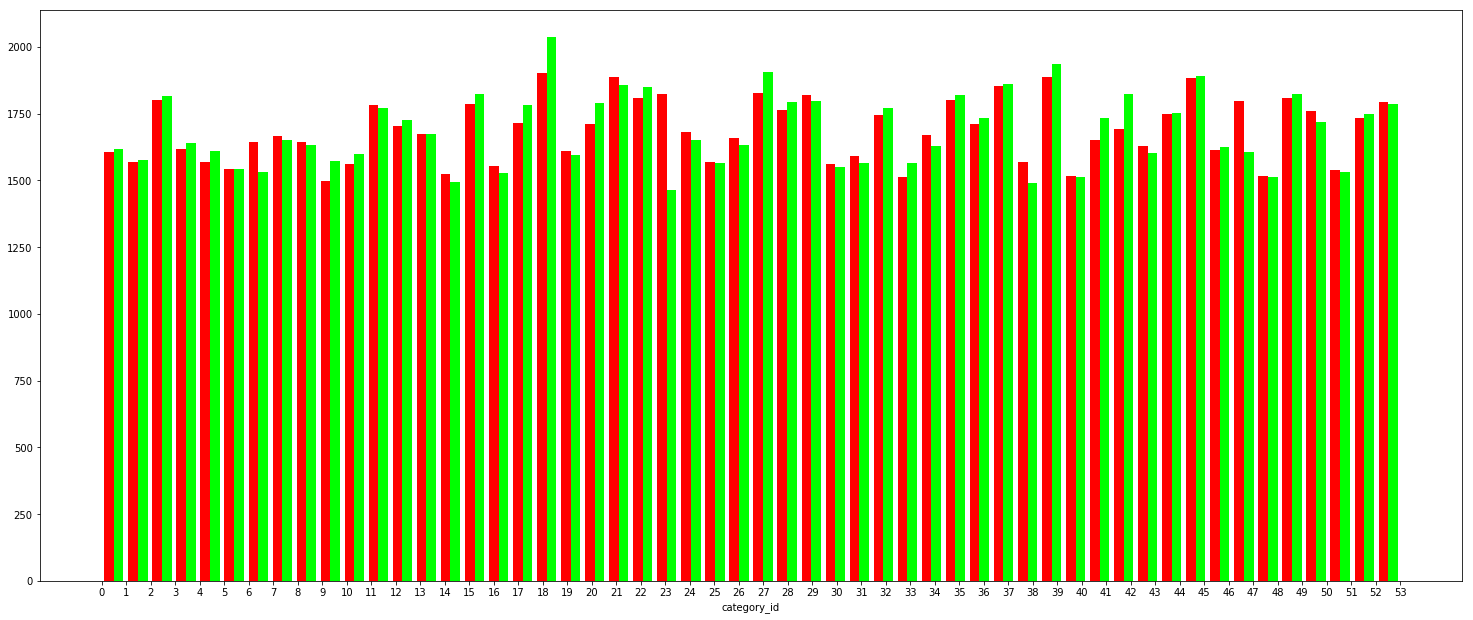

In [104]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(25.5, 10.5)


colors = ['red', 'lime']
array = np.hstack([np.asarray(y_val).reshape(-1,1), np.asarray(preds_val).reshape(-1,1)])
plt.xticks(np.arange(0, 54, 1.0))
ax.hist(array, bins=54, color=colors, label=colors)
ax.set_xlabel('category_id')

plt.show();


# Делаем предсказания для тестовой выборки

In [0]:
data_test = read_data("xgb_test_data.csv")
preds_test = xgb.predict(data_test.values)

In [93]:
original_test_data = read_data('test.csv')

test_preds = pd.DataFrame([original_test_data.item_id.values, preds_test], ).T
test_preds.columns = ['item_id', 'category_id']
test_preds = test_preds.set_index('item_id')
test_preds.head(3)

,category_id
item_id,
489517,22
489518,0
489519,15


In [0]:
assert test_preds.shape[0] == original_test_data.shape[0]
save_data(test_preds, "Предсказания для тестовой выборки.csv")